# Running OSOS

This notebook demonstrates how you can run OSOS from python. This allows you to dive in deeper to the usage stats, especially the github metrics. 

If you have not already run OSOS from the CLI, you should do that too. The OSOS CLI is a general purpose tool that you can use to pull usage stats for your projects straight from the command line. You can also run the CLI for several projects using a config file. Try running `osos --help` from the command line to get started with the CLI.

In [1]:
import datetime
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from osos import Github, Pypi

sns.set_style("darkgrid")

In [2]:
msg = 'You need to set your github token in the GITHUB_TOKEN environment variable or input the string here explicitly'
token = os.getenv('GITHUB_TOKEN', None)
assert token is not None, msg

# Init a Github API 

In [3]:
Github?

Init signature: Github(owner, repo, token=None)
Docstring:      Class to call github api and return osos-formatted usage data.
Init docstring:
Parameters
----------
owner : str
    Repository owner, e.g. https://github.com/{owner}/{repo}
repo : str
    Repository name, e.g. https://github.com/{owner}/{repo}
token : str | None
    Github api authorization token. If none this gets retrieved from
    the GITHUB_TOKEN environment variable
File:           ~/code/osos/osos/api_github/api_github.py
Type:           type
Subclasses:     


In [4]:
gh = Github('NREL', 'reV', token=token)
gh

Github API interface for https://github.com/NREL/reV/

# Find Closed Issues Statistics

In [5]:
gh.issues_closed?

Signature: gh.issues_closed(get_lifetimes=False, **kwargs)
Docstring:
Get data on the closed repo issues.

Parameters
----------
get_lifetimes : bool
    Flag to get the lifetime statistics of issues/pulls. Default is
    false to reduce number of API queries. Turning this on requires
    that we get the full data for every issue/pull. It is recommended
    that users retrieve lifetime statistics manually when desired and
    not as part of an automated OSOS workflow.
kwargs : dict
    Optional kwargs to get passed to requests.get()

Returns
-------
out : int | dict
    Number of closed issues, or if get_lifetimes is True, this returns
    a dict with additional metrics.
File:      ~/code/osos/osos/api_github/api_github.py
Type:      method


In [6]:
gh.issues_closed()

151

In [7]:
issues = gh.issues_closed(get_lifetimes=True)
issues.keys()

dict_keys(['issues_closed', 'issues_closed_count', 'issues_closed_lifetimes', 'issues_closed_mean_lifetime', 'issues_closed_median_lifetime'])

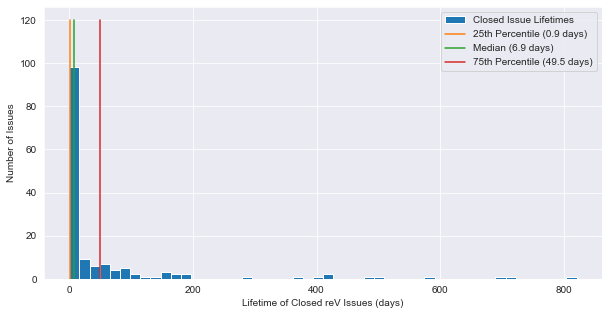

In [8]:
plt.figure(figsize=(10, 5))
median = issues['issues_closed_median_lifetime']
p25 = np.percentile(issues['issues_closed_lifetimes'], 25)
p75 = np.percentile(issues['issues_closed_lifetimes'], 75)
h = plt.hist(issues['issues_closed_lifetimes'], bins=50)[2]
a = plt.plot([p25, p25], [0, 120])[0]
b = plt.plot([median, median], [0, 120])[0]
c = plt.plot([p75, p75], [0, 120])[0]
plt.xlabel('Lifetime of Closed reV Issues (days)')
plt.ylabel('Number of Issues')
plt.legend([h, a, b, c], 
           ['Closed Issue Lifetimes', 
            '25th Percentile ({:.1f} days)'.format(p25),
            'Median ({:.1f} days)'.format(median),
            '75th Percentile ({:.1f} days)'.format(p75)]
          )

# Find Commits

In [9]:
gh.commits?

Signature: gh.commits(date_start=None, date_iter=None, search_all=False, **kwargs)
Docstring:
Get the number of commits by day in a given set of dates.

Parameters
----------
date_start : datetime.date | None
    Option to search for commits from this date to today. Either input
    this or the date_iter.
date_iter : list | tuple | pd.DatetimeIndex | None
    Iterable of dates to search for. Either input this or the
    date_start.
search_all : bool
    Flag to search all commits or to terminate early (default) when the
    commit date is before all dates in the date_iter
kwargs : dict
    Optional kwargs to get passed to requests.get()

Returns
-------
out : pd.DataFrame
    Timeseries of commit data based on date_iter as the index. Includes
    columns for "commits".
File:      ~/code/osos/osos/api_github/api_github.py
Type:      method


In [10]:
date_start = datetime.date.today() - datetime.timedelta(days=180)
commits = gh.commits(date_start=date_start)

In [11]:
commits

,commits
2021-05-23,0
2021-05-24,1
2021-05-25,4
2021-05-26,0
2021-05-27,1
...,...
2021-11-15,1
2021-11-16,0
2021-11-17,0
2021-11-18,0


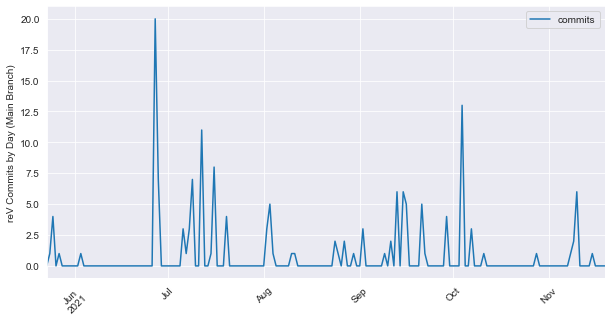

In [12]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)
commits.plot(ax=ax)
plt.ylabel('reV Commits by Day (Main Branch)')
_ = plt.xticks(rotation=45)

# PyPI Stats

In [13]:
Pypi.get_data?

Signature: Pypi.get_data(name, include_mirrors=False)
Docstring:
Get the dataframe for the last 180 days of download data

Parameters
----------
name : str
    pypi package name. Note that this should include the prefix for
    nrel packages e.g. reV -> nrel-rev
include_mirrors : bool
    Flag to include mirror downloads or not

Returns
-------
out : pd.DataFrame
    DataFrame of pypistats data for the last 180 days with:
    "pypi_daily" and "pypi_180_cumulative". Note that the
    180 day cumulative is for the last 180 days from today's actual
    date, not 180 days from the date in the output row index.
File:      ~/code/osos/osos/api_pypi/api_pypi.py
Type:      function


In [14]:
pdata = Pypi.get_data('nrel-rev', include_mirrors=False)
pdata

,pypi_daily,pypi_180_cumulative
date,,
2021-05-22,3,3
2021-05-23,7,10
2021-05-24,7,17
2021-05-25,18,35
2021-05-26,2,37
...,...,...
2021-11-14,51,3501
2021-11-15,5,3506
2021-11-16,165,3671


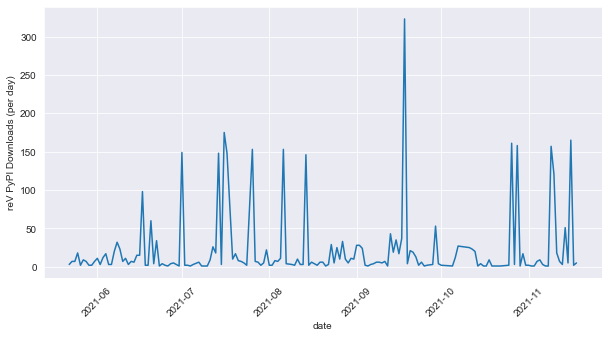

In [15]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)
pdata['pypi_daily'].plot()
plt.ylabel('reV PyPI Downloads (per day)')
_ = plt.xticks(rotation=45)

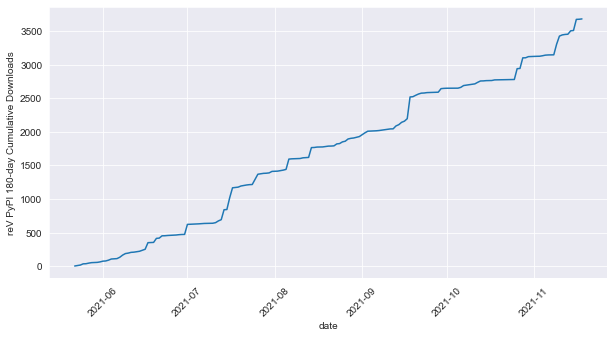

In [16]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)
pdata['pypi_180_cumulative'].plot()
plt.ylabel('reV PyPI 180-day Cumulative Downloads')
_ = plt.xticks(rotation=45)